<h1> DEEP TRANSFER LEARNING ON MEDICAL IMAGES

Research and work carried out by Brizzi Anouk and Oxisoglou Thomas as part of a research project supervised by Mr. Ronan Sicre for the end of the first year of the Master's program at the Faculty of Aix-Marseille, IAAA option.

Its aim is to test the transfer learning method on medical image classification. To do this, we used a brain tumor dataset, available here : https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

This document presents the results of our best model.

In [ ]:
#All imports required for the project
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import matshow
import matplotlib.cm as cm
from IPython.display import Image, display
import numpy as np
import pandas as pd

import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, ActivityRegularization, Lambda, Input,GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, MaxPooling1D, Conv1D
from keras.layers import AveragePooling2D, Input
from keras.utils import np_utils
from keras.utils import normalize
from keras.utils import load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import image

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B3,EfficientNetV2L,ResNet50V2,MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
#For this project, all the images in the dataset were transferred to a drive, so you'll need to do the same for the rest of the project.
from google.colab import drive
drive.mount('drive')

In [ ]:
#Access path to test and train folders.
train_path = 'drive/MyDrive/brain-tumor-classification-mri/Training'
test_path = 'drive/MyDrive/brain-tumor-classification-mri/Testing'

<h1>Data set analysis

In [ ]:
#We count the number of images per category in each folder.

print("Train :")
listDir = sorted(os.listdir(train_path))
cpt = 0
for d in listDir:
    listFiles = sorted(os.listdir(train_path+'/'+d))
    print(d," :",len(listFiles))
    cpt+=len(listFiles)
print("Total train file :",cpt)

print("\nTest :")
listDir = sorted(os.listdir(test_path))
cpt = 0
for d in listDir:
    listFiles = sorted(os.listdir(test_path+'/'+d))
    print(d," :",len(listFiles))
    cpt+=len(listFiles)
print("Total test file :",cpt)

In [ ]:
classes = []

for sf in os.listdir(train_path):
  classes.append(sf)

print(classes)

<h1> Data pre-processing

In [ ]:
X_train = []
y_train = []
img_size = 150

for i in classes:
  listFiles = sorted(os.listdir(train_path+'/'+i))
  for f in listFiles:
        tmp = [0,0,0,0]
        tmp[classes.index(i)]=1
        img = load_img(train_path+'/'+i+'/'+f)
        img = tf.image.resize(img,(img_size,img_size))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X_train.append(x[0,:,:,:])
        y_train.append(tmp)
  listFiles = sorted(os.listdir(test_path+'/'+i))
  for f in listFiles:
        tmp = [0,0,0,0]
        tmp[classes.index(i)]=1
        img = load_img(test_path+'/'+i+'/'+f)
        img = tf.image.resize(img,(img_size,img_size))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        X_train.append(x[0,:,:,:])
        y_train.append(tmp)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
#Data augmentation of our dataset
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)

In [ ]:
#Dividing our data into trains/tests with 20% for testing
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=42,stratify=y_train)

<h1> Model creation

In [ ]:
#importing the pre-trained model
base_model = EfficientNetV2B3(weights='imagenet',include_top=False, input_shape=(img_size,img_size,3))

52606240/52606240 [==============================] - 4s 0us/step


In [ ]:
#displays the layers of the imported pre-trained model
print(base_model.summary())

In [ ]:
#Allows you to freeze or unfreeze the model
base_model.trainable = False

In [ ]:
#Adding our customized layers
med_model = Sequential()
med_model.add(base_model)
med_model.add(Dense(512,activation='relu'))
med_model.add(GlobalAveragePooling2D())
med_model.add(Dropout(0.5))
med_model.add(Dense(4, activation='softmax'))

In [ ]:
#Layer of our customized model
print(med_model.summary())

<h1> Learning

In [ ]:
#Custom optimizer with best learning rate found
opt = keras.optimizers.Adam(learning_rate=0.0009, beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [ ]:
#compilation of our model
med_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Learning rate reduction factor when the model does not improve.
reduce_lr1 = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.9, patience = 2, min_delta = 0.001,mode='auto',verbose=1)

In [ ]:
#We start learning our model
result = med_model.fit(X_train, y_train, batch_size=32, epochs=100,callbacks = [reduce_lr1], validation_split=0.1, verbose=1)

<h1> Results analysis

<h2> Evaluating our model

In [ ]:
loss,acc = med_model.evaluate(X_test, y_test)

21/21 [==============================] - 2s 81ms/step - loss: 0.1652 - accuracy: 0.9786
score= 0.16521649062633514
accuracy =  0.9785605072975159


In [ ]:
print("loss =", loss)
print("accuracy = ", acc)

<h2> Result curve for our model

Text(0, 0.5, 'score')

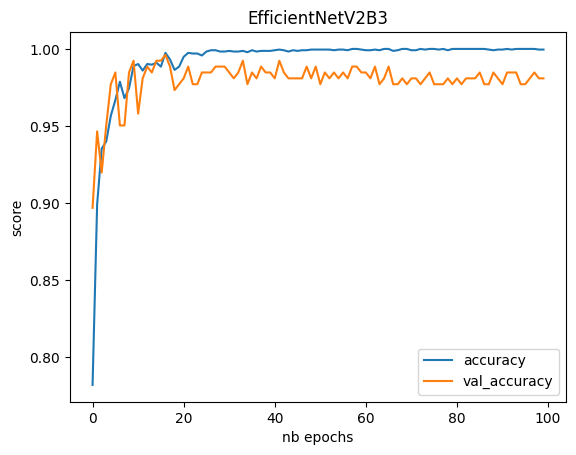

In [ ]:
plt.plot(range(0,100),loss.history['accuracy'],label='accuracy')
plt.plot(range(0,100),loss.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.title('EfficientNetV2B3')
plt.xlabel('nb epochs')
plt.ylabel('score')

<h3> Confusion matrix of our model

In [ ]:
y_pred=med_model.predict(X_test)
y_test_arg = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred,axis=1)
print(confusion_matrix(y_test_arg, y_pred))

<h1> Interpretability

In [ ]:
decode_predictions = keras.applications.efficientnet_v2.decode_predictions
#Couche avant celle de résultat à rentrer
last_conv_layer_name = "dense_8"

In [ ]:
#Heatmap via gradcam, version given by keras here : https://keras.io/examples/vision/grad_cam/


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
glioma_path = "drive/MyDrive/brain-tumor-classification-mri/Testing/glioma_tumor/image(21).jpg"
preprocess_input = keras.applications.efficientnet_v2.preprocess_input
img_array = preprocess_input(get_img_array(glioma_path, size=(img_size,img_size)))

img = load_img(glioma_path)
img = tf.image.resize(img,(img_size,img_size))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

print("Predicted class : ",np.argmax(med_model.predict(x)))

1/1 [==============================] - 3s 3s/step
0


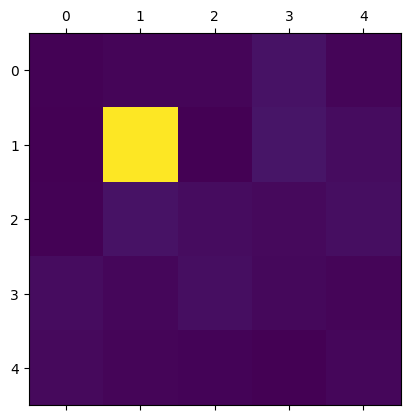

In [ ]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, med_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-113-2ae84804d58b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


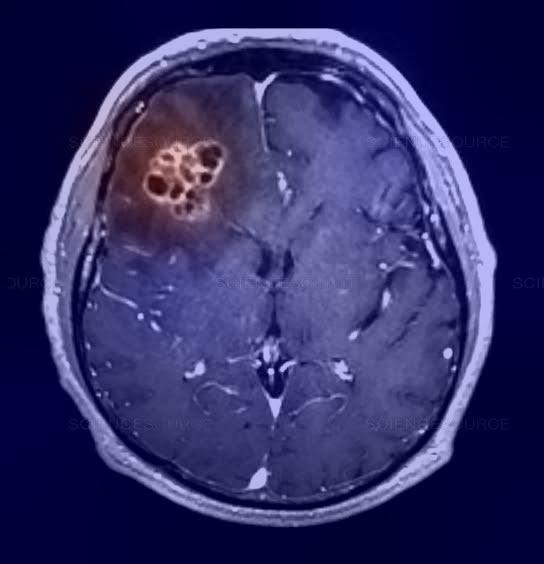

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(glioma_path, heatmap)